Genetic Algorithms
----

Genetic Algorithms (GAs) are optimization inspired by the principles of natural selection and genetics, drawing inspiration from the "survival of the fittest". These algorithms are designed to mimic the process of natural selection to find approximate solutions to optimization and search problems. 

In a genetic algorithm, we generate several candidate solutions or chromosomes that form a 'population'. This population of solutions undergoes evolution using mutations and crossovers. Mutations are functions that introduce random changes to a chromosome (with some probability), and crossovers are functions that combine two solutions into a new, third 'offspring'. After the population undergoes mutation and produces an additional set of offspring solutions using crossovers, we retain some number of the best solutions from the total population. The process is repeated until the population converges. 

[Notes on Genetic Algorithms - Raj Venkat](https://venkat.prof/resources/AI/ch4#genetic_algo)

For a more detailed write-up on Genetic Algorithms, visit : https://natureofcode.com/genetic-algorithms/

In this section, we will try to solve linear regression using genetic algorithms.

A line in $n$ dimensions is represented by the equation: $y = c_0 + c_1 x_1 + c_2 x_2 + \dots + c_n x_n$

Here, $\{c_0, c_1, \dots, c_n\}$ are coefficients that we will try to optimize using genetic algorithms such that the line described by these coefficients best fits our data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

**Data Generation**: For this lab, we will first generate some random data that roughly fits a line in 2 dimensions. 

To do so, we first pick a line (such as $y=2x+4$). Now for a given set of values of $x$, \
we can first generate a corresponding value of the $y$ coordinate by simply using the equation of the line, $y=2x=4$. 

These pairs ($x,y$) would lie exactly on the line. However, for our data to be a bit more realistic,\
we want the data points to be slightly away from the line in either direction.

To achieve this, we can add a small random amount of noise $\epsilon$ to each $y$ coordinate,\
offsetting the placement of the point in 2-D space away from the line by $\epsilon$.\
Let us assume the noise lies in the range [$-5,5$]. Therefore, $\epsilon = \texttt{random}(-5,5)$ and $y=2x+4+\epsilon$.

In higher dimensions (e.g., for a plane in 3-D space $y=c_0 + c_1 x_1 + c_2 x_2$), for each point $\mathbf{x} = [1, x_1, x_2, \dots, x_n]^T$, given coefficients $\mathbf{c}=[c_0, c_1, c_2, \dots, c_n]$ we generate the corresponding points $\mathbf{y}=\mathbf{c}\cdot \mathbf{x} \pm \epsilon$.

In [4]:
def generate_data(coefficients):    
    # TODO: generate a numpy array X of 100 random points with dimension len(coefficients)
    # with each entry in the matrix X in the range [0,100]
    # Ensure the value in the first (dummy) dimension is always 1, to account for the bias term (c_0).
    X = np.random.rand(100, len(coefficients)) * 100
    # For each point x in X, generate the corresponding value of y as y = c.x + epsilon
    # Make sure epsilon is different for every point x, and lies in the range [-5,5]
    # Use numpy operations instead of loops for efficiency
    epsilon = np.random.rand(100) * 10 - 5
    coefficients = np.array(coefficients)
    y = X.dot(coefficients) + epsilon
    return X, y, epsilon

Great! Now let's verify that your function behaves as expected, by generating some 2D data around the line $y=4+2x$, and visualizing it.\
Simply execute the cell below. You should expect to see data that *almost* lies along a straight line. 

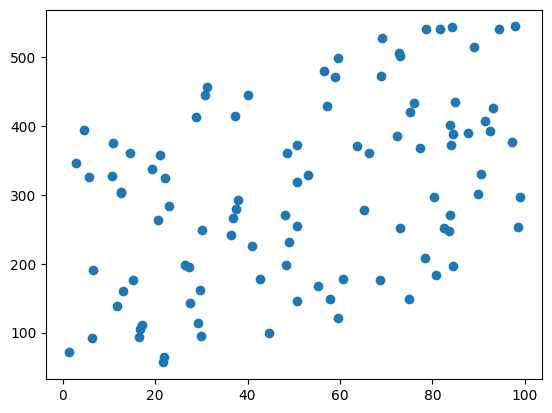

In [5]:
X_train, y_train, noise = generate_data([4,2])
plt.scatter(X_train[:,1:], y_train) # Ignore dummy dimension while plotting

**Fitness Function**: We now define a function that will tell us how good a given solution is.
Recall that a solution in this setting is simply a set of coefficients,\
so a single solution may look like the vector \[4, 2\].
This particular solution, of course, is the optimal one, and what we hope our algorithm converges to.

Also, recall that a given set of coefficients defines a line (in 2 dimensions, a plane in 3 dimensions...).\
The fitness function simply evaluates how well this line fits our data.

For linear regression, we are interested in minimizing the distance between the line and all our data points.\
Define your fitness function below that leverages the **sum total** of the square of the vertical distances\
between the line and each data point. In other words, this is the residual sum of squared distances:
$\sum_{i=1}^n (y_i - c\cdot x_i)^2$

Since we are interested in minimizing the sum of squared distance, our *fitness* function should return the negative of the above quantity.

In [6]:
def fitness_function(coefficients, X, y):
    residual_sum_of_squares =  np.sum((y - X.dot(coefficients))**2)
    return -residual_sum_of_squares  # returning the negative residual sum of squares

**Population Initialization**: In the cell below, complete the function to initialize your population of candidate solutions\
or chromosome $\mathbf{G} = \{\mathbf{g_1}, \mathbf{g_2}, \dots, \mathbf{g_n}\}$.
Each candidate is a vector with as many entries as the number of coefficients.\
Each entry should be an integer in the range \[-10,10\].

Define this as a numpy array to make operations easier and more efficient in later steps.

In [7]:
def initialize_population(pop_size, num_coefficients):
    population = np.random.randint(-10, 11, size=(pop_size, num_coefficients))
    return population

**Natural Selection**: We define three functions below that together represent the 'natural selection' aspect of GAs. \
Note that this lab presents only one of several variants of GAs; several complex strategies exist for each of these functions.

1. Parent Selection - This function selects a subset of candidate solutions, that will then be combined to produce new offspring. <br /> This could be done using many strategies, but for simplicity, we assume that we pick the top 20% of solutions in terms of the fitness function.

2. Crossover - A crossover operator combines two parent solutions into one or more offspring solutions. <br /> In this lab, we simply average the two parents (element-wise) to produce a single offspring. <br />For instance, if the parent solutions are \[1,3,5\] and \[5,4,-8\] respectively, then the crossover yields \[(1+5)/2, (3+4)/2, (5-8)/2\] = \[3, 3.5, -1.5\].

3. Mutation - Finally, we make small changes to each new offspring solution with some small probability. <br />In this context, a change simply entails adding a small amount of noise to each dimension of each offspring chromosome<br /> (except the dummy dimension) with some probability $p$.

In [8]:
 # Function to select best fitted parents
def select_parents(population, fitness):
    selected_indices = np.argsort(-fitness)[:int(0.2*len(population)) if len(population)%2==0 else int(0.2*len(population))+1]
    return population[selected_indices]

# Function to perform crossover
def crossover(parents):
    return np.mean(parents, axis=0)

# Function to perform mutation in genetic algorithms
def mutate(individuals):
    mutation_rate = 0.2
    is_mutated = np.random.random((len(individuals), len(individuals[0]))) <= mutation_rate
    mutation = np.random.randint(-5, 5, (len(individuals), len(individuals[0])))
    return individuals + (is_mutated * mutation)

**TODO**

Do you think these are the best possible variants of these operations for our task? Can you think of other implementations of the parent selection, crossover and mutation operators?

Answer: 
The implementations of the genetic algorithm (GA) operations serve as a solid foundation for a basic GA. However, as with most evolutionary algorithms, there's a wide variety of ways each component can be implemented, each with its own set of advantages and disadvantages depending on the specific problem context. The alternatives are as follows:

1. Parent Selection
The above implementation selects the top 20% of solutions based on fitness, which is a form of truncation selection. This approach is straightforward and effective for ensuring that only the fittest individuals contribute genes to the next generation. However, it can lead to premature convergence and a loss of genetic diversity. Other methods include:

- Tournament Selection: Selects a number of individuals randomly and then chooses the best out of these to become a parent. This method can maintain diversity better than truncation selection.
- Roulette Wheel Selection: Individuals are selected based on their fitness proportionate to the total fitness of the population, which allows for a greater chance of selecting fitter individuals while still giving a chance to less fit individuals.
- Rank Selection: Individuals are ranked based on their fitness, and the selection probability is determined based on this ranking rather than the fitness values directly, helping to avoid issues with scale.

2. Crossover
The above crossover operator averages two parents element-wise. This method is simple and preserves the mean of the parent genes, but it may not always introduce enough variability to explore the solution space effectively. Alternative methods include:

- Single-Point Crossover: A point on the parent chromosomes is selected randomly, and the genes are exchanged between the two parents from this point to the end of the chromosome to create offspring.
- Two-Point Crossover: Similar to single-point but involves two points. The genes between the two points are swapped between the parents, generating more diversity.
- Uniform Crossover: For each gene, the offspring inherits the gene from either parent with equal probability, increasing genetic diversity.

3. Mutation
The above mutation approach randomly adds a small amount of noise to each dimension of each offspring with a certain probability. This can help maintain genetic diversity but might be too random. Other approaches include:

- Gaussian Mutation: Adds a random value from a Gaussian distribution to the genes. This can be more natural for problems with a notion of small, incremental changes.
- Adaptive Mutation Rates: Adjusting the mutation rate based on the progress of the algorithm. For example, starting with a higher mutation rate to explore the space and reducing it as the population converges to maintain diversity without losing good solutions.
- Gene-specific Mutation Rates: Different genes might have different mutation rates based on their importance or expected variability in the problem domain.


In [13]:
# This function specifies a stop criteria, where we check the fitness function of the best chromosome from the pool.
# Recall that the Residual Sum of Squares Error is minimized when the error is 0 (perfect fit), therefore the fitness
# function (negative of RSS Error) has an upper bound of 0. The closer we are to 0, the better the fit. Here, we consider that an error of 
# greater than -3 is a good enough fit. Feel free to tweak this value and observe the effects.
def meets_stop_criteria(best_error):
    if best_error<=3:
        return True
    return False

**Control Flow**: We now define the central logic of how our GA works. We initialize the population size and specify a number of generations for the algorithm to run. These values default to 10 and 20 respectively.

Once we initialize a population, we compute every individual's fitness score and select the top 20% for crossover. From our list of parent chromosomes, we pick pairs at random without replacement and combine them using crossover (if we start with 10 parents, we get 5 offspring in this implementation). 

Each offspring chromosome is then mutated using the function we defined earlier. Finally, the generated offspring replace the same number of lowest-scoring individuals in the original population (i.e., if we have 5 offspring, then we replace the 5 lowest scoring individuals).

In [10]:
def genetic_algorithm(X, y, pop_size=10, num_generations=20):
    num_coefficients = len(X[0])
    population = initialize_population(pop_size, num_coefficients)
    for generation in range(num_generations):
        fitness = np.array([fitness_function(individual, X, y) for individual in population])
        
        #print("Fitness Scores: ", fitness)
        parents = select_parents(population, fitness)
        #print("Selected Parents: ", parents)

        # Apply crossover to create new individuals by randomly pairing selected parents without replacement
        # HINT: One possible implementation might combine np.random.shuffle, np.stack and list comprehension
        offspring = [crossover((parents[i], parents[i+1])) for i in range(0, len(parents), 2)]

        
        #print("Offspring from Crossover: ", offspring) --> Uncomment for debugging

        # Apply mutations to each offspring individual
        offspring = mutate(offspring)
        
        #print("Offspring after Mutations: ", offspring) --> Uncomment for debugging

        # Update population by replacing the k weakest chromosomes with the k generated offspring for the next generation
        population[np.argsort(fitness)[:len(offspring)]] = offspring
        
        #print("Updated Population: ", population) --> Uncomment for debugging
        
        best_individual = population[np.argmax(fitness)]
        best_error = fitness_function(best_individual, X, y)
        #print(f"Generation: {generation}, Best Error: {best_error})
        if meets_stop_criteria(best_error):
            break
    return best_individual

In [11]:
# Executes the genetic algorithm
def run_genetic_algorithm(num_cofficients,population_size,num_generations):
    X, y, epsilon = generate_data(num_cofficients)
    
    # Run genetic algorithm for linear regression
    best_coefficients = genetic_algorithm(X, y,population_size,num_generations)
    print("Best coefficients are:", best_coefficients)

In [15]:
# Feel free to experiment with these values
cofficients = [2, 3, 6, 8, 10]
population_size = 200
num_generations = 600

run_genetic_algorithm(cofficients, population_size, num_generations)

Best coefficients are: [4 3 6 7 7]


#TODO:
How efficient do you think genetic algorithm defined was in getting the correct coefficients to solve the linear equations? What other tasks do you think genetic algorithms can solve?

Answer:
The genetic algorithm defined in this notebook is a simple and effective way to solve the linear regression problem. It is able to find the coefficients that minimize the sum of squared distances between the line and the data points. However, the efficiency of the algorithm depends on the problem and the specific implementation of the genetic algorithm operations. For the linear regression problem, the genetic algorithm can be quite effective, especially when the problem is complex and the search space is large.

Genetic algorithms can be used to solve a wide variety of optimization problems, including:
1. Function Optimization: Finding the maximum or minimum of a function, especially in cases where the function is non-linear, non-convex, or has many local optima.
2. Feature Selection: Selecting the most relevant features from a large set of features to improve the performance of machine learning models.
3. Scheduling Problems: Optimizing the allocation of resources, such as time, personnel, or equipment, to achieve specific objectives.
4. Vehicle Routing: Finding the most efficient routes for vehicles to deliver goods or services to multiple locations.
5. Neural Network Training: Optimizing the weights and biases of neural networks to improve their performance on specific tasks.
6. Image Processing: Optimizing image processing algorithms to enhance image quality, remove noise, or detect specific features.

In general, genetic algorithms can be applied to any problem that can be formulated as an optimization problem, especially when the search space is large and complex, and traditional optimization methods are not effective.